In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm

from scipy.special import gamma, digamma, gammaln

In [4]:
num_runs = 12

base_path = "data/high_school/"

# alpha
file_path_alpha = base_path + "output_2012/alpha_store_"
alpha_list = []
for i in range(num_runs):
    file_path = file_path_alpha + f"{i}.pkl"
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    f.close()
    alpha_list.append(data)

# beta
file_path_beta = base_path + "output_2012/beta_store_"
beta_list = []
for i in range(num_runs):
    file_path = file_path_beta + f"{i}.pkl"
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    f.close()
    beta_list.append(data)

# n
file_path_n = base_path + "output_2012/n_store_"
n_list = []
for i in range(num_runs):
    file_path = file_path_n + f"{i}.pkl"
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    f.close()
    n_list.append(data)

# tau
file_path_tau = base_path + "output_2012/tau_store_"
tau_list = []
for i in range(num_runs):
    file_path = file_path_tau + f"{i}.pkl"
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    f.close()
    tau_list.append(data)

In [6]:
df_sim_params = pd.read_pickle('data/high_school/code_2012/df_high_school_2012_params.pkl')

In [7]:
df_sim_params

,num_nodes,num_groups,n_cavi,delta_z,delta_pi,delta_lam
0,180,5,3,1,1.0,1.0
1,180,5,3,1,1.0,0.1
2,180,5,3,1,0.1,1.0
3,180,5,3,1,0.1,0.1
4,180,5,4,1,1.0,1.0
5,180,5,4,1,1.0,0.1
6,180,5,4,1,0.1,1.0
7,180,5,4,1,0.1,0.1
8,180,5,5,1,1.0,1.0
9,180,5,5,1,1.0,0.1


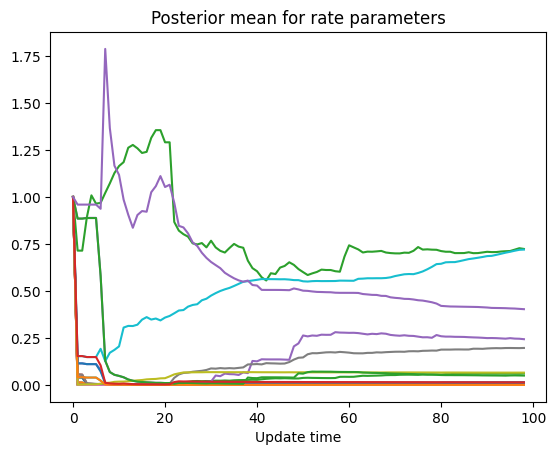

In [44]:
T_max = 100; int_length = 1

# Plot the mean of the posteriors for lambda with iteration number
for index in [0]:
    num_groups = df_sim_params.loc[index, 'num_groups']
    alpha = alpha_list[index]; beta = beta_list[index]
    for j in range(num_groups):
            for k in range(num_groups):
                    plt.plot(np.arange(int(T_max/int_length) - 1),
                            [alpha[i,j,k] / beta[i,j,k] for i in np.arange(T_max - 1)])
            
plt.xlabel("Update time")
# plt.ylabel(r"Posterior means");
plt.title("Posterior mean for rate parameters");

Global group membership probabilities

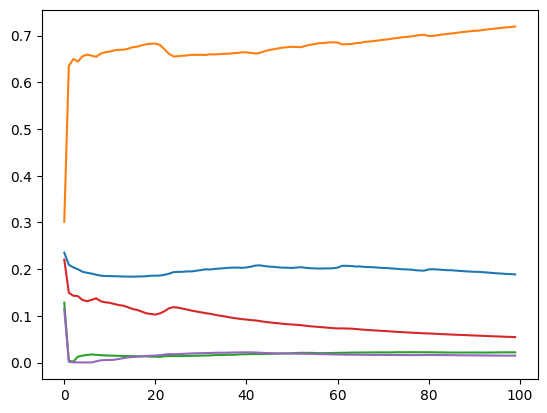

In [37]:
for index in [0]:
    n_store = n_list[index]
    global_prob = n_store / n_store.sum(axis=1, keepdims=True)
    num_groups = df_sim_params.loc[index, 'num_groups'] 
    for group in range(num_groups):
        plt.plot(np.arange(T_max), global_prob[:,group])

Average of nodes-level probabilities

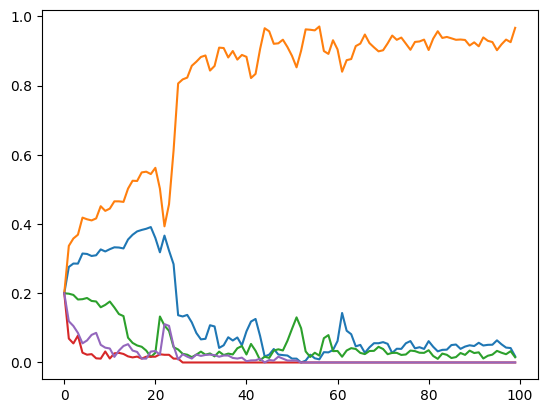

In [38]:
for index in [5]:
    tau_store = tau_list[index]
    num_groups = df_sim_params.loc[index, 'num_groups']
    for group in range(num_groups):
        plt.plot(np.arange(T_max), [tau_store[i,:,group].mean() for i in range(T_max)])

Load in true groups and compute statistics

In [25]:
true_groups = pd.read_csv('data/high_school/data_2012/true_groups_2012.txt',
                    names=['i', 'Ci', 'Gender'],
                    sep='\t')

In [26]:
round(true_groups['Ci'].value_counts() / len(true_groups), 3)

Ci
PSI*    0.228
PC      0.211
MP*2    0.194
PC*     0.194
MP*1    0.172
Name: count, dtype: float64

In [107]:
true_groups.Ci.unique()

array(['PC', 'PSI*', 'PC*', 'teacher'], dtype=object)

In [75]:
for index in [0]:
    n_store = n_list[index]
    global_prob = n_store / n_store.sum(axis=1, keepdims=True)
    num_groups = df_sim_params.loc[index, 'num_groups'] 
    for group in range(num_groups):
        print(f"Proportion in Group {group}: {round(global_prob[-1,group],3)}")

Proportion in Group 0: 0.265
Proportion in Group 1: 0.376
Proportion in Group 2: 0.359


Individual node level

In [64]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta

df_hs = pd.read_csv('data/high_school/data_2012/thiers_2012.csv',
                    names=['time_UNIX', 'i', 'j', 'Ci', 'Cj'],
                    sep='\t')

# Read true groups
true_groups = pd.read_csv("data/high_school/data_2012/true_groups_2012.txt",
                          names=['i', 'Ci', 'gender'],
                          sep='\t')

# Mappings
node_mapping = {element: i for i, element in enumerate(true_groups.i)}
group_mapping = {element: i for i, element in enumerate(true_groups.Ci.unique())}
df_hs['Ci'] = df_hs['Ci'].map(group_mapping)
df_hs['Cj'] = df_hs['Cj'].map(group_mapping)
df_hs['i'] = df_hs['i'].map(node_mapping)
df_hs['j'] = df_hs['j'].map(node_mapping)

# Map UNIX ctime and get seconds elapsed since start of the day. Time corresponds
# to whether there was an observation on [t-20, t]
df_hs['time_real'] = df_hs['time_UNIX'].apply(lambda x: datetime.fromtimestamp(x))
df_hs['date'] = df_hs['time_real'].dt.date
date_mapping = {element: i for i, element in enumerate(df_hs.date.unique())}
start_time_day = df_hs.groupby('date')['time_real'].transform('min')
df_hs['time'] = (df_hs['time_real'] - start_time_day).dt.total_seconds()
df_hs['date'] = df_hs['date'].map(date_mapping)

df_hs_rest = df_hs[['date', 'time', 'i', 'j', 'Ci', 'Cj']]

for day in [0]:
    # Select day
    df_hs_temp = df_hs_rest[df_hs_rest.date == day].drop(columns='date')

    # Map times to an interval of [0,100] 
    #  1 time step is then (max_time / 100)
    max_time = df_hs_temp['time'].max()
    df_hs_temp.loc[:,'time'] = df_hs_temp.loc[:,'time'] / max_time * 100


In [71]:
df_hs_temp.groupby(['Ci'])['Ci'].value_counts()

Ci
0    2615
1     884
2    2247
3    1270
4    2941
Name: count, dtype: int64

(0.0, 100.0)

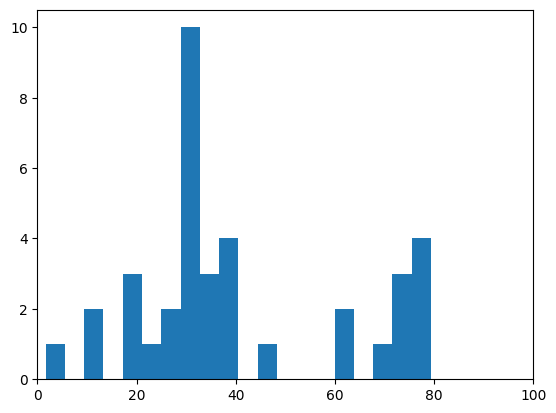

In [99]:
node = 170
data_node = df_hs_temp[df_hs_temp.i == node].time
plt.hist(data_node, bins=20);
plt.xlim([0,100])